In [27]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib

In [28]:
def preprocess_data(features, labels=None):
    if labels is not None:
        features = features.join(labels)
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)
    features = features.interpolate(method="quadratic")
    if labels is not None:
        return features.drop('total_cases', axis=1), features['total_cases']
    else:
        return features

def get_data(features_path, labels_path=None):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = preprocess_data(sj_features, sj_labels)
        iq_f, iq_l = preprocess_data(iq_features, iq_labels)
        return sj_f, sj_l, iq_f, iq_l

    return preprocess_data(sj_features, None), preprocess_data(iq_features, None)


In [29]:
sj_X_data, sj_y_data, iq_X_data, iq_y_data = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv')

# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [30]:
def roll(df_in, n):
    df = df_in.copy()
    for i in df.columns:
        if i != 'weekofyear':
            df[i] = df[i].rolling(n,min_periods=1).mean()
    return df

In [31]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_data, sj_y_data, test_size=0.3, shuffle=False)

iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_data, iq_y_data, test_size=0.3, shuffle=False)

'''sj_X_train = sj_X_data
sj_y_train = sj_y_data

iq_X_train = iq_X_data
iq_y_train = iq_y_data'''

sj_X_train = roll(sj_X_train,3)
iq_X_train = roll(iq_X_train,3)

In [32]:
sj_X_train

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,18,0.122600,0.103725,0.198483,0.177617,12.420000,297.572857,297.742857,292.414286,299.800000,...,32.000000,73.365714,12.420000,14.012857,2.628571,25.442857,6.900000,29.400000,20.000000,16.000000
1990-05-07,19,0.146250,0.122950,0.180420,0.166551,17.620000,297.892143,298.092857,293.182857,300.350000,...,24.970000,75.367143,17.620000,14.692857,2.500000,26.078571,6.635714,30.550000,21.100000,12.300000
1990-05-14,20,0.108250,0.139622,0.172680,0.167982,23.260000,298.188571,298.354762,293.933333,300.400000,...,25.346667,77.595714,23.260000,15.411429,2.433333,26.290476,6.585714,31.100000,21.666667,22.000000
1990-05-21,21,0.110261,0.186736,0.182371,0.187405,24.240000,298.660000,298.850000,294.898571,300.933333,...,19.313333,79.919524,24.240000,16.298095,2.366667,26.966667,6.542857,32.400000,22.766667,18.000000
1990-05-28,22,0.119028,0.226744,0.211986,0.218023,19.140000,299.095714,299.257143,295.521905,301.266667,...,17.400000,80.950000,19.140000,16.910476,2.580952,27.709524,7.542857,33.500000,23.333333,17.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-10-29,44,-0.076866,-0.034667,0.185552,0.192400,44.826667,300.512381,300.559524,296.451429,302.400000,...,28.400000,78.595238,44.826667,17.914286,2.557143,27.690476,7.000000,32.400000,23.500000,30.233333
2002-11-05,45,0.052417,-0.009610,0.240514,0.235429,18.946667,300.502381,300.576190,296.242857,302.366667,...,23.733333,77.668095,18.946667,17.686190,2.723810,27.638095,6.761905,32.033333,23.500000,31.000000
2002-11-12,46,0.138861,0.027215,0.256433,0.248591,15.780000,300.501429,300.652381,295.846667,302.366667,...,17.266667,75.856190,15.780000,17.257619,2.790476,27.414286,6.709524,31.300000,23.133333,14.500000


In [33]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,655.0,26.810687,14.858483,1.000000,14.000000,27.000000,40.000000,53.000000
ndvi_ne,655.0,0.086316,0.076044,-0.133153,0.042224,0.079133,0.124629,0.372556
ndvi_nw,655.0,0.085229,0.093876,-0.556937,0.054458,0.085275,0.128389,0.329883
ndvi_se,655.0,0.170084,0.083869,-0.543294,0.151963,0.176919,0.202683,0.324029
ndvi_sw,655.0,0.163765,0.048030,-0.107228,0.141264,0.166551,0.190121,0.292194
precipitation_amt_mm,655.0,34.324190,27.197601,-10.623456,13.423333,31.353333,48.216667,167.710000
reanalysis_air_temp_k,655.0,299.016805,1.130561,296.357143,298.020238,299.299524,299.961190,301.149524
reanalysis_avg_temp_k,655.0,299.124853,1.100769,296.495238,298.139286,299.376190,300.041667,301.247619
reanalysis_dew_point_temp_k,655.0,295.059621,1.485791,290.622381,293.716667,295.464762,296.318333,297.441905
reanalysis_max_air_temp_k,655.0,301.252159,1.118588,298.766667,300.300000,301.400000,302.166667,303.433333


In [34]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,364.0,26.431319,14.973924,1.000000,13.750000,26.000000,39.000000,53.000000
ndvi_ne,364.0,0.267164,0.051773,0.125887,0.228309,0.270034,0.304564,0.400393
ndvi_nw,364.0,0.233888,0.047296,0.126106,0.198732,0.234410,0.269572,0.354132
ndvi_se,364.0,0.251835,0.051024,0.117860,0.213223,0.248261,0.287018,0.393041
ndvi_sw,364.0,0.264346,0.053170,0.135729,0.227565,0.258468,0.300994,0.457491
precipitation_amt_mm,364.0,64.406429,23.615478,4.053333,48.795000,64.421667,79.016667,139.140000
reanalysis_air_temp_k,364.0,297.857416,1.026952,295.392857,297.181548,297.818095,298.533929,301.086190
reanalysis_avg_temp_k,364.0,299.131034,1.134071,296.240476,298.332143,299.064286,299.962023,302.111905
reanalysis_dew_point_temp_k,364.0,295.319267,1.300631,292.254762,294.261786,295.648095,296.430952,297.407619
reanalysis_max_air_temp_k,364.0,307.196587,2.073730,302.533333,305.625000,306.958333,308.575000,313.300000


In [35]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

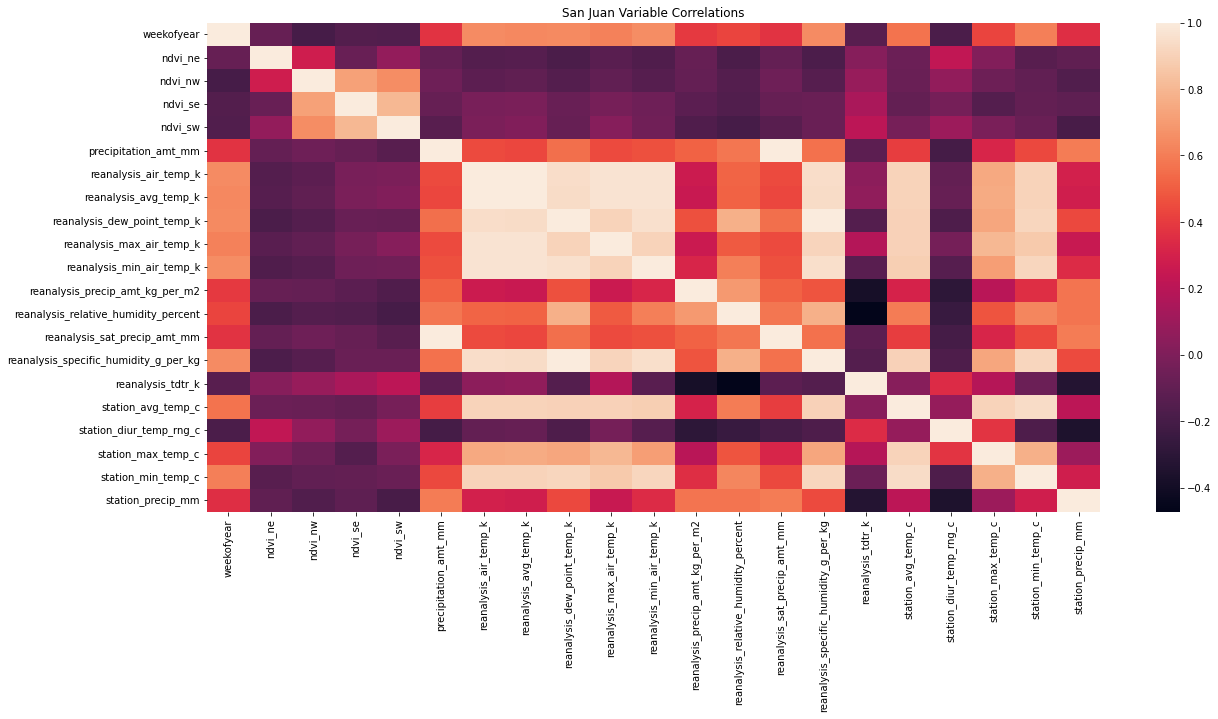

In [36]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [37]:
sj_rf = RandomForestRegressor(100, min_samples_leaf=5)
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

12.292162471868135
27.419408508254072


In [38]:
sj_rf.feature_importances_

array([0.10264883, 0.01151082, 0.03838553, 0.5668143 , 0.03091351,
       0.00463802, 0.00738121, 0.0047747 , 0.03311655, 0.00876276,
       0.00761829, 0.04072188, 0.02186616, 0.00703904, 0.02882895,
       0.01065384, 0.01120906, 0.01247584, 0.00943052, 0.02079855,
       0.02041164])

<AxesSubplot:ylabel='cols'>

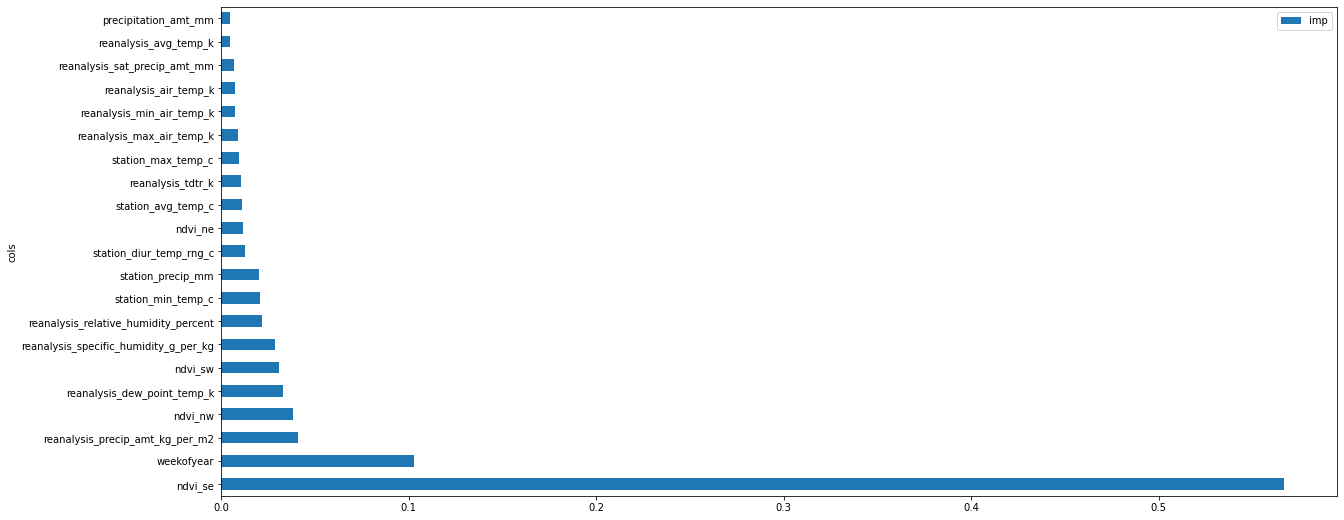

In [39]:
plt.rcParams["figure.figsize"] = (20,9)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [40]:
iq_rf = RandomForestRegressor(100, min_samples_leaf=5)
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

3.2025480418532983
7.6832283625615885


In [41]:
iq_rf.feature_importances_

array([0.11411981, 0.02227951, 0.04482285, 0.0534354 , 0.02333013,
       0.04077246, 0.01288195, 0.03243176, 0.0567191 , 0.01617997,
       0.09730807, 0.07429637, 0.01916709, 0.03968087, 0.06719928,
       0.0253227 , 0.05892344, 0.04684106, 0.02415769, 0.10167063,
       0.02845985])

<AxesSubplot:ylabel='cols'>

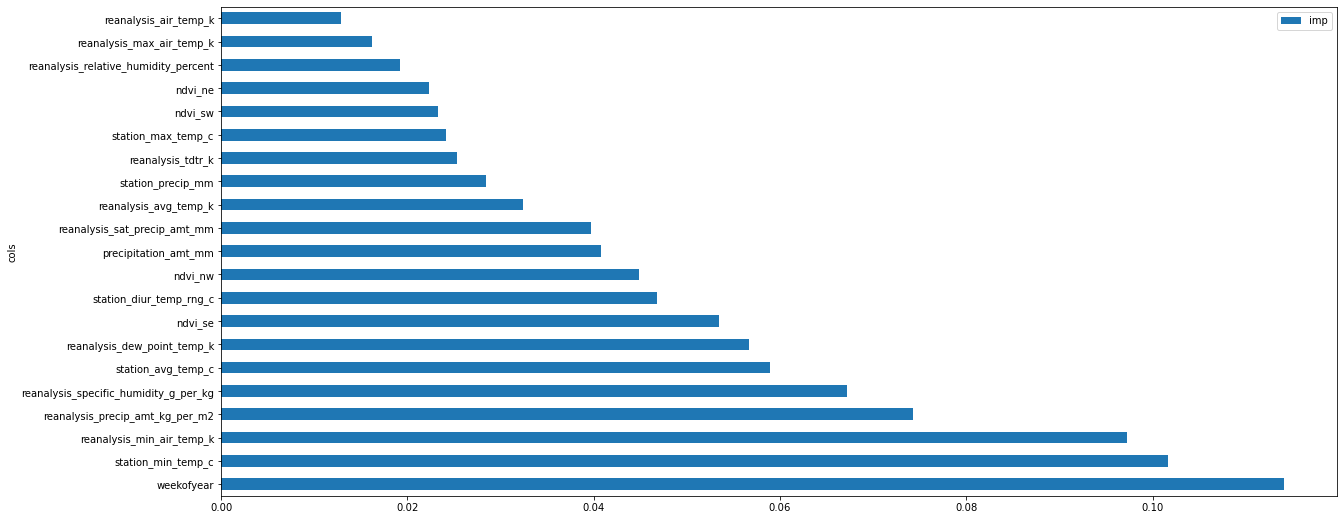

In [42]:
plt.rcParams["figure.figsize"] = (20,9)
plt.rcParams["figure.figsize"] = (20,9)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

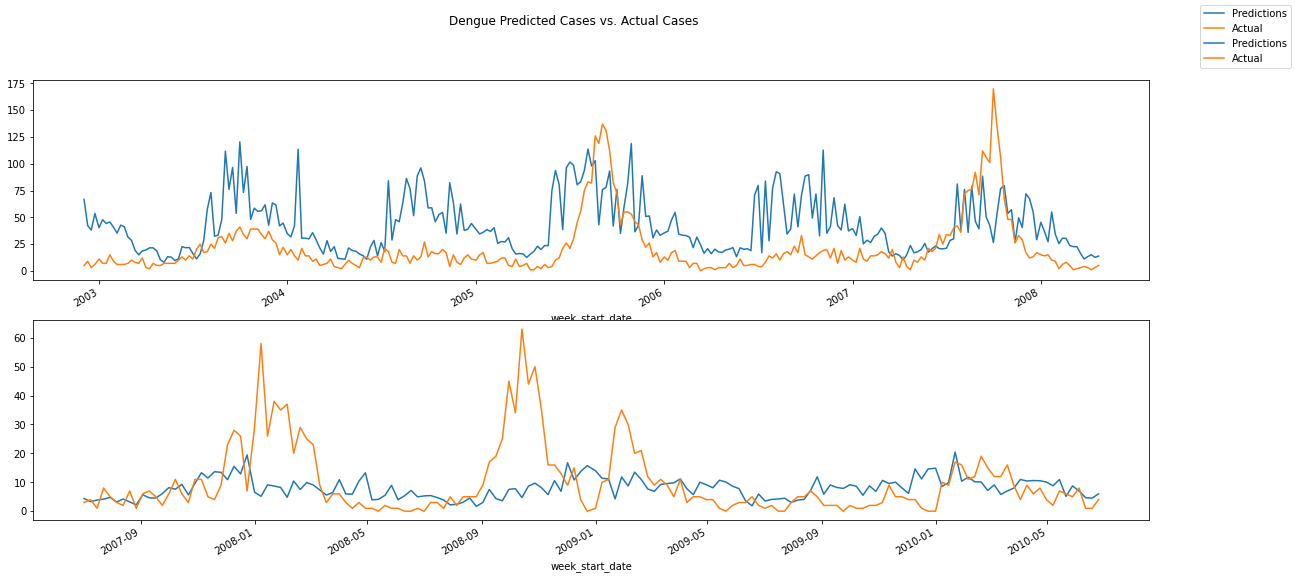

In [43]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [44]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [45]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv') 

In [46]:
sj_X_valid

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2008-05-06,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2008-05-13,20,-0.001500,-0.031051,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
2008-05-20,21,0.052862,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
2008-05-27,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,13,-0.087400,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,301.3,...,2.55,78.780000,30.34,15.985714,3.314286,27.542857,7.942857,33.9,22.8,3.5
2013-04-02,14,-0.203250,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,...,64.30,81.650000,6.55,15.881429,2.828571,26.642857,6.642857,33.3,22.8,17.6
2013-04-09,15,-0.117600,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,301.5,...,0.70,78.285714,0.00,16.212857,3.171429,27.914286,8.114286,32.8,23.3,9.4


In [47]:
iq_X_valid

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,26,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,...,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
2010-07-09,27,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,...,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
2010-07-16,28,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,...,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
2010-07-23,29,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,...,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8
2010-07-30,30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,...,18.93,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,...,67.60,89.990000,41.12,17.185714,10.100000,27.400,9.050,32.6,21.8,33.0
2013-06-04,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,...,45.70,93.891429,71.52,17.448571,9.657143,27.520,10.720,33.8,21.4,68.0
2013-06-11,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,...,45.22,94.967143,78.96,16.410000,7.385714,27.200,10.075,32.6,21.6,93.2


In [48]:
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

In [49]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 27.419408508254072
iq 7.6832283625615885


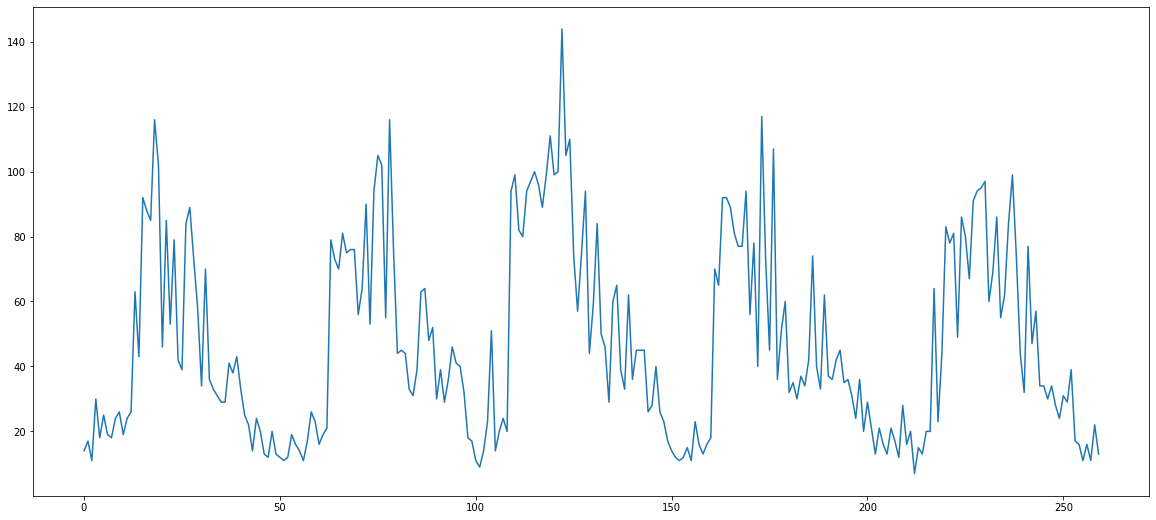

In [50]:
plt.plot(sj_predictions)

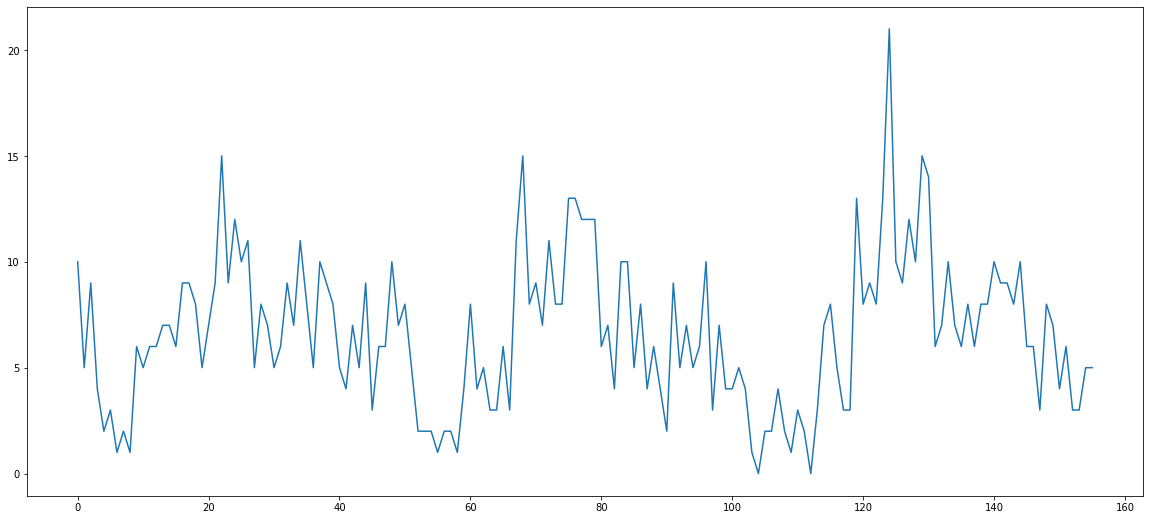

In [51]:
plt.plot(iq_predictions)

In [52]:
joblib.dump(sj_rf,'sj_rf.pkl')
joblib.dump(iq_rf, 'iq_rf.pkl')

['iq_rf.pkl']